# Beta-binomial model
The goal of this notebook is to provide a step-by-step guide for conducting a Bayesian A/B test using the beta-binomial model. We will assume that we are testing two versions of a website, a control version (A) and a variation (B). Our metric of interest is the resulting CTR across 2 channels.

To illustrate the process, we will use a sample dataset that contains `trials = number of visitors` and `success = conversions` for each version of the website over a certain time period.

Here is an example of what the data might look like:

In [1]:
from bb_helpers import *
import numpy as np
import pandas as pd

In [2]:
# Define a dictionary with the data for the AB test
data = {
    'metric': ['CTR (Channel A)', 'CTR (Channel B)'],
    'trials_A': [80000, 1000],
    'success_A': [1600, 120],
    'trials_B': [80000, 1000],
    'success_B': [1696, 90]
}

df = pd.DataFrame(data)

In [3]:
# Calculate the conversion rates for each version
p_A = df['success_A'] / df['trials_A']
p_B = df['success_B'] / df['trials_B']
df = df.assign(p_A=p_A.values, p_B=p_B.values)

In [4]:
df.head()

,metric,trials_A,success_A,trials_B,success_B,p_A,p_B
0,CTR (Channel A),80000,1600,80000,1696,0.02,0.0212
1,CTR (Channel B),1000,120,1000,90,0.12,0.0900


We will assume that the CTR for version A is the baseline conversion rate, and we want to determine whether version B has a higher or lower conversion rate.

# Setting a Beta prior
For now, we'll proceed a non-informative prior by setting `alpha_0 = beta_0 = 1`.

In [5]:
alpha_0 = 1
beta_0 = 1

# Update beta prior

In [6]:
# Calculate the updated parameters for the beta prior for version A
params_A = df.apply(lambda x: update_beta_prior(
    x['trials_A'], x['success_A'], alpha_0, beta_0), axis=1)

# Calculate the updated parameters for the beta prior for version B
params_B = df.apply(lambda x: update_beta_prior(
    x['trials_B'], x['success_B'], alpha_0, beta_0), axis=1)

In [7]:
# Add the updated parameters for the beta prior to the DataFrame
df = df.assign(alpha_A=params_A.apply(lambda x: x[0]).values,
               beta_A=params_A.apply(lambda x: x[1]).values,
               alpha_B=params_B.apply(lambda x: x[0]).values,
               beta_B=params_B.apply(lambda x: x[1]).values)

In [8]:
df.head()

,metric,trials_A,success_A,trials_B,success_B,p_A,p_B,alpha_A,beta_A,alpha_B,beta_B
0,CTR (Channel A),80000,1600,80000,1696,0.02,0.0212,1601,78401,1697,78305
1,CTR (Channel B),1000,120,1000,90,0.12,0.0900,121,881,91,911


# Bayesian inference

In [9]:
# Calculate the difference between the beta distributions for versions A and B
dbeta = df.apply(lambda x: dbeta_B_minus_A(
    x['alpha_A'], x['beta_A'], x['alpha_B'], x['beta_B']), axis=1)

# Calculate the probability that version B is higher than version A
prob_B_higher = dbeta.apply(lambda x: x.sf(0))

In [10]:
# Add the difference and probability to the DataFrame
df = df.assign(dbeta=dbeta, prob_B_higher=prob_B_higher.values)

In [11]:
df.head()

,metric,trials_A,success_A,trials_B,success_B,p_A,p_B,alpha_A,beta_A,alpha_B,beta_B,dbeta,prob_B_higher
0,CTR (Channel A),80000,1600,80000,1696,0.02,0.0212,1601,78401,1697,78305,<scipy.stats._distn_infrastructure.rv_continuo...,0.954407
1,CTR (Channel B),1000,120,1000,90,0.12,0.0900,121,881,91,911,<scipy.stats._distn_infrastructure.rv_continuo...,0.014534


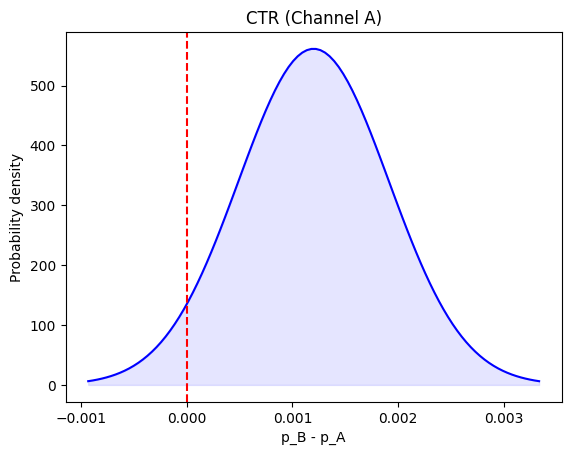

Variant A performed p_A = 2.00% while p_B = 2.12%.
p_B is +0.12pp higher than p_A.
You can be 95% confident that this is a result of the changes you made and not a result of random chance.


In [12]:
explain_prob_B_higher(df, 0)

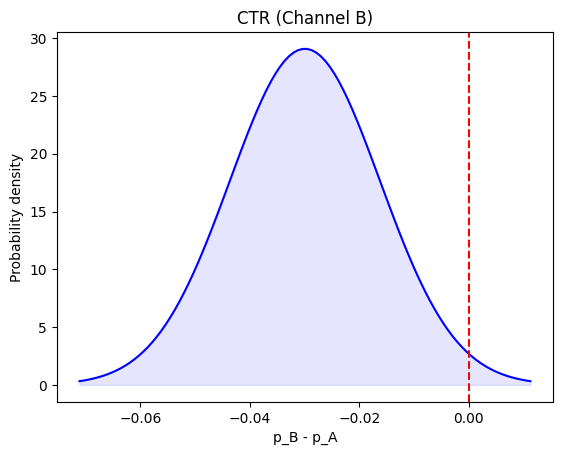

Variant A performed p_A = 12.00% while p_B = 9.00%.
p_B is -3.0pp lower than p_A.
You can be 99% confident that this is a result of the changes you made and not a result of random chance.


In [13]:
explain_prob_B_higher(df, 1)